In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as mpl
import numpy as np
import scipy.stats as st
import calendar
from sklearn.mixture import GaussianMixture
import datetime



new_cases_df = pd.read_csv("Assignment 2_datasets\Assignment 2_datasets/1.COVID-19_daily_number_of_new_cases_and_deaths.csv", sep=",")
vaccination_df = pd.read_csv("Assignment 2_datasets/Assignment 2_datasets/2.COVID-19_vaccination.csv", sep=",")
icu_df = pd.read_csv("Assignment 2_datasets\Assignment 2_datasets/3.COVID-19_hospital_and_ICU_admission_rates.csv", sep=",")

# Cleaning process new_cases_df
- get rid of unessesary data
- drop duplicates
- missing values
    - Checked for NaN rows in each column individually
    - cases and deaths are the only columns with missing values in new_case_df
- check that colunms are consistent/formating
- outliers
    Due to some contries compenstaing for reporting to high with negative values another day we can't detect outliers.



In [2]:
display(new_cases_df)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,23/10/2022,23,10,2022,3557.0,0.0,Austria,AT,AUT,8901064,Europe
1,22/10/2022,22,10,2022,5494.0,4.0,Austria,AT,AUT,8901064,Europe
2,21/10/2022,21,10,2022,7776.0,4.0,Austria,AT,AUT,8901064,Europe
3,20/10/2022,20,10,2022,8221.0,6.0,Austria,AT,AUT,8901064,Europe
4,19/10/2022,19,10,2022,10007.0,8.0,Austria,AT,AUT,8901064,Europe
...,...,...,...,...,...,...,...,...,...,...,...
28724,08/02/2020,8,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
28725,07/02/2020,7,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
28726,06/02/2020,6,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe
28727,05/02/2020,5,2,2020,0.0,0.0,Sweden,SE,SWE,10327589,Europe


In [3]:
new_cases_df = new_cases_df.loc[new_cases_df["countriesAndTerritories"] != "Liechtenstein"]


new_cases_df.drop_duplicates()

def repair_by_month(column):
    grouped_df = new_cases_df.groupby(['countriesAndTerritories','year','month']) #group by month, year and country
    for name,group in grouped_df: #for each group
        country = name[0] #get month
        year = name[1] #get year
        month = name[2] #get country

        try:
            moast_frequent = group[column].value_counts().idxmax() #get the most frequent value
        except ValueError:
            print(country,month,year) #print the country, month and year of the error
            moast_frequent = 0 #set the most frequent value to 0
        new_cases_df.loc[(new_cases_df['countriesAndTerritories'] == country) & (new_cases_df['month'] == month) & (new_cases_df['year'] == year), column] = new_cases_df.loc[(new_cases_df['countriesAndTerritories'] == country) & (new_cases_df['month'] == month) & (new_cases_df['year'] == year), column].fillna(moast_frequent)

repair_by_month("deaths") #repair the deaths column
repair_by_month("cases") #repair the cases column


Iceland 2 2020
Norway 2 2020


In [4]:
def repair_dates_formatting():
    for index,row in new_cases_df.iterrows():
        new_cases_df.loc[index, "dateRep"] = datetime.datetime(new_cases_df.loc[index, "year"], new_cases_df.loc[index, "month"], new_cases_df.loc[index, "day"]).date()
repair_dates_formatting()

#### Formating columns with floats to int

In [5]:
new_cases_df['cases'] = new_cases_df['cases'].astype(int)
new_cases_df['deaths'] = new_cases_df['deaths'].astype(int)

# Now you can use the modified 'cases' and 'deaths' columns in the original DataFrame
new_cases_df.loc[:, ['cases', 'deaths']] = new_cases_df[['cases', 'deaths']].values.copy()

# Verify the updated DataFrame
display(new_cases_df)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,2022-10-23,23,10,2022,3557,0,Austria,AT,AUT,8901064,Europe
1,2022-10-22,22,10,2022,5494,4,Austria,AT,AUT,8901064,Europe
2,2022-10-21,21,10,2022,7776,4,Austria,AT,AUT,8901064,Europe
3,2022-10-20,20,10,2022,8221,6,Austria,AT,AUT,8901064,Europe
4,2022-10-19,19,10,2022,10007,8,Austria,AT,AUT,8901064,Europe
...,...,...,...,...,...,...,...,...,...,...,...
28724,2020-02-08,8,2,2020,0,0,Sweden,SE,SWE,10327589,Europe
28725,2020-02-07,7,2,2020,0,0,Sweden,SE,SWE,10327589,Europe
28726,2020-02-06,6,2,2020,0,0,Sweden,SE,SWE,10327589,Europe
28727,2020-02-05,5,2,2020,0,0,Sweden,SE,SWE,10327589,Europe


### From the block below we can see that there are no outliars in the popData2020 column because there's only one unique value for each country.

In [6]:
import scipy.stats as st

# Gets all unique values for the population by country
population_per_country = new_cases_df.groupby("countriesAndTerritories")["popData2020"].unique()

population_per_country

countriesAndTerritories
Austria         [8901064]
Belgium        [11522440]
Bulgaria        [6951482]
Croatia         [4058165]
Cyprus           [888005]
Czechia        [10693939]
Denmark         [5822763]
Estonia         [1328976]
Finland         [5525292]
France         [67320216]
Germany        [83166711]
Greece         [10718565]
Hungary         [9769526]
Iceland          [364134]
Ireland         [4964440]
Italy          [59641488]
Latvia          [1907675]
Lithuania       [2794090]
Luxembourg       [626108]
Malta            [514564]
Netherlands    [17407585]
Norway          [5367580]
Poland         [37958138]
Portugal       [10295909]
Romania        [19328838]
Slovakia        [5457873]
Slovenia        [2095861]
Spain          [47332614]
Sweden         [10327589]
Name: popData2020, dtype: object

In [7]:

grouped_df = new_cases_df.groupby(['countriesAndTerritories','year', 'month'])

is_normal = True

for info, groupby in grouped_df:
    country = info[0] #get country
    year = info[1] #get year
    month = info[2] #get month

    groupby = groupby.loc[(groupby['countriesAndTerritories'] == country) & (groupby['month'] == month) & (groupby['year'] == year)]

    # print(country, month, year)
    if len(groupby['deaths']) > 3:
            if groupby['deaths'].nunique() > 1:  # Check for non-zero range
                stat, p_value = st.shapiro(groupby['deaths'])
                if p_value < 0.05:
                    is_normal = False
                    print(f"Data for {country} is not normal")
            else:
                is_normal = False
                print(f"Data for {country} has zero range")
    else:
        print("Not enough data")

print(f"There is normal distribution: {is_normal}")




Data for Austria has zero range
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Austria is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Belgium is not normal
Data for Bulgaria is not normal
Data for Bulgaria is not normal
Data 

# Cleaning  COVID-19 vaccinations Dataset

46% missing data in denominator column, and because the questions doen't require comperasions agains specific age-groups we decided to remove it alltogether

In [8]:
missingvalues = vaccination_df["FirstDoseRefused"].isna().sum()/len(vaccination_df["FirstDoseRefused"])
print(f"Percentage of missing values in FirstDoseRefused: {round(missingvalues,4)*100}%")

missingvaluesdenominator = vaccination_df["Denominator"].isna().sum()/len(vaccination_df["Denominator"])
print(f"Percentage of missing values in Denominator: {round(missingvaluesdenominator,4)*100}%")

Percentage of missing values in FirstDoseRefused: 99.79%
Percentage of missing values in Denominator: 46.93%


In [9]:
vaccination_df.drop_duplicates()
vaccination_df["NumberDosesReceived"] = vaccination_df["NumberDosesReceived"].fillna(0) #fill the missing values with 0
vaccination_df["NumberDosesExported"] = vaccination_df["NumberDosesExported"].fillna(0) #fill the missing values with 0
vaccination_df.drop(columns=['FirstDoseRefused'], inplace=True) #removes the column since it has 99.78762127016277% missing values
vaccination_df.drop(columns=['Denominator'], inplace=True)  #removes the column since it has 46.934525119985906% missing values

print(vaccination_df.isna().sum())

YearWeekISO            0
ReportingCountry       0
NumberDosesReceived    0
NumberDosesExported    0
FirstDose              0
SecondDose             0
DoseAdditional1        0
DoseAdditional2        0
DoseAdditional3        0
DoseAdditional4        0
DoseAdditional5        0
UnknownDose            0
Region                 0
TargetGroup            0
Vaccine                0
Population             0
dtype: int64


## Cleaning 3rd dataset
Theres no values in the url column, therefore we'll remove it completly

In [10]:
icu_df = icu_df.drop_duplicates()
icu_df = icu_df.drop(columns=['url'], axis=1)
icu_df.isna().sum()  


country      0
indicator    0
date         0
year_week    0
value        0
source       0
dtype: int64

In [11]:
icu_df.groupby(["indicator"]).count() #Daily metric is most common indicator, therefore we will convert all other indicators to daily metric

,country,date,year_week,value,source
indicator,,,,,
Daily ICU occupancy,8842,8842,8842,8842,8842
Daily hospital occupancy,10984,10984,10984,10984,10984
Weekly new ICU admissions per 100k,2358,2358,2358,2358,2358
Weekly new hospital admissions per 100k,2916,2916,2916,2916,2916


Extracts weekly data from indicator and value columns and then converts it to daily data by dividing by 7 and changing the indicator name

In [12]:
mask = icu_df["indicator"].isin(["Weekly new ICU admissions per 100k", "Weekly new hospital admissions per 100k"]) #mask for weekly indicators
icu_df.loc[mask, 'value'] = (icu_df.loc[mask, 'value'] / 7) #convert weekly indicators to daily indicators

icu_df['indicator'] = icu_df['indicator'].replace({
    "Weekly new ICU admissions per 100k": "Daily new ICU admissions per 100k",
    "Weekly new hospital admissions per 100k": "Daily new hospital admissions per 100k",
    "Daily hospital occupancy": "Daily hospital occupancy per 100k",
    "Daily ICU occupancy": "Daily ICU occupancy per 100k" 
}) #replace weekly indicators with daily indicators

icu_df.to_csv("icu_df.csv", index=True)

# Questions:

# Q1: 
Since 2020 till 2022, which top-10 countries reported the most number of
cases of COVID-19 in quarters per year (Q1-Q4 in each year)? Do you find
these numbers relatively high compared to the country’s population? Do
you see any connection among these countries regarding their geographical locations and the period that most cases are observed? Discuss your
observations

In [13]:
new_cases_df["dateRep"] = pd.to_datetime(new_cases_df["dateRep"],infer_datetime_format=True) #convert dateRep to datetime
new_cases_df["Period"] = new_cases_df["dateRep"].dt.to_period('Q') #add a column with the quarter
new_cases_grouped_Q = new_cases_df.groupby(["Period","countriesAndTerritories"]) #group by quarter and country
new_cases_grouped_Q = new_cases_grouped_Q.sum().sort_values("cases",ascending=False).head(10)


# Q3

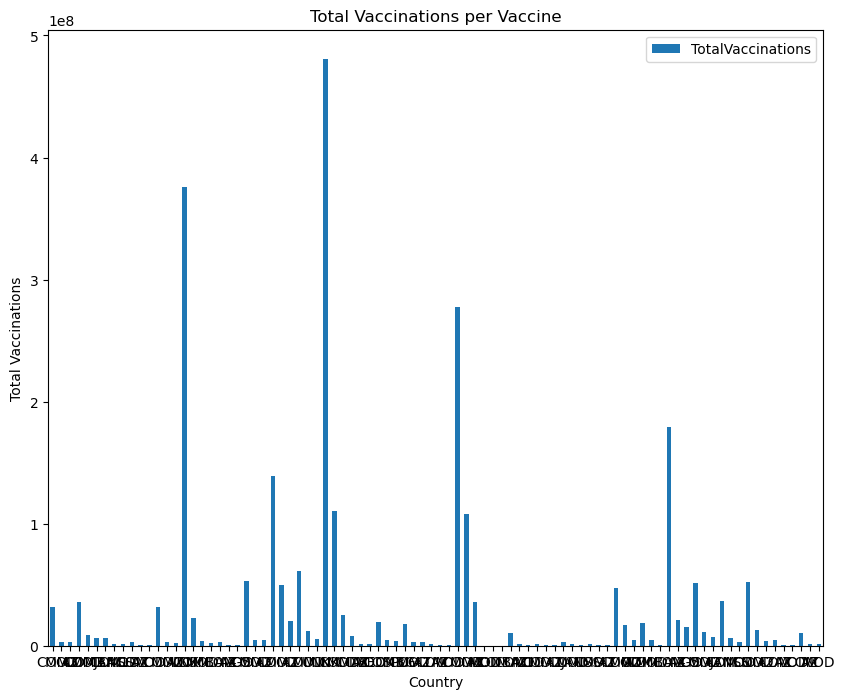

In [16]:
vaccination_count_per_country = vaccination_df.groupby(["ReportingCountry", "Vaccine"]).sum()
vaccination_count_per_country['TotalVaccinations'] = vaccination_count_per_country[['FirstDose', 'SecondDose', 'DoseAdditional1', 'DoseAdditional2', 'DoseAdditional3', 'DoseAdditional4', 'DoseAdditional5', 'UnknownDose']].sum(axis=1)
# display(vaccination_count_per_country)

summary_data = vaccination_count_per_country.groupby(['ReportingCountry','Vaccine'])['TotalVaccinations'].sum().reset_index()
total_vaccine_data_sum = summary_data.groupby(['Vaccine'])['TotalVaccinations'].sum().reset_index().sort_values(by=['TotalVaccinations'], ascending=False)
top_3_vaccines_total = total_vaccine_data_sum.nlargest(3, 'TotalVaccinations')
sorted_summary_data = summary_data.sort_values(by=['ReportingCountry','TotalVaccinations'], ascending=[True, False])
top_3_vaccines_per_country = sorted_summary_data.groupby(['ReportingCountry']).head(3)
# display(top_3_vaccines_per_country)

top_3_vaccines_per_country.plot.bar(x='Vaccine', y='TotalVaccinations', rot=0, figsize=(10, 8), stacked=True)

mpl.xlabel('Country')
mpl.ylabel('Total Vaccinations')
mpl.title('Total Vaccinations per Vaccine')

mpl.show()